In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchmetrics
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_from_disk, DatasetDict, load_dataset
import torchaudio
import random

SEED = 42
SAMPLE_RATE = 16000
BATCH_SIZE = 16
NUM_WORKERS = 12
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

/home/pierre/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
ds = load_dataset("Usernameeeeee/df_462700_2")

In [4]:
LABELS = ds["train"].features["label"]

if not isinstance(ds, DatasetDict):
    ds = ds.train_test_split(test_size=0.3, seed=SEED)
    test_and_valid = ds["test"].train_test_split(test_size=0.5, seed=SEED)
    ds = DatasetDict({
        "train": ds["train"],
        "valid": test_and_valid["train"],
        "test": test_and_valid["test"],
    })

print("Dataset splits:", {k: v.shape for k, v in ds.items()})
print("Label names:", LABELS.names)

Dataset splits: {'train': (462701, 3)}
Label names: ['other', 'drone']


In [31]:
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64,
)
db_transform = torchaudio.transforms.AmplitudeToDB()

def preprocess(example):
    audio = example["audio"]

    # Handle either dict or list formats
    if isinstance(audio, dict) and "array" in audio:
        waveform = torch.tensor(audio["array"]).float()
    else:
        waveform = torch.tensor(audio).float()

    # Make sure waveform is 1D
    if waveform.ndim > 1:
        waveform = waveform.mean(dim=0)  # convert stereo to mono

    mel = mel_transform(waveform)
    mel_db = db_transform(mel)

    # Ensure tensor type (and contiguous memory)
    example["mel"] = mel_db.clone().detach().float()
    return example


ds = ds.map(preprocess)

Map:   3%|▎         | 8532/323890 [00:27<17:02, 308.31 examples/s]


KeyboardInterrupt: 

In [12]:
LABELS = ds["train"].features["label"]

# Split the "train" dataset into train + test
ds_split = ds["train"].train_test_split(test_size=0.3, seed=SEED)

# Split the test portion into validation + test
test_and_valid = ds_split["test"].train_test_split(test_size=0.5, seed=SEED)

# Create a new DatasetDict
ds = DatasetDict({
    "train": ds_split["train"],
    "valid": test_and_valid["train"],
    "test": test_and_valid["test"],
})

print("Dataset splits:", {k: v.shape for k, v in ds.items()})
print("Label names:", LABELS.names)

Dataset splits: {'train': (323890, 4), 'valid': (69405, 4), 'test': (69406, 4)}
Label names: ['other', 'drone']


In [33]:
import torch
import torchaudio

def collate_fn(batch):
    SAMPLE_RATE = 16000  # set this properly for your data
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=64,
    )
    db_transform = torchaudio.transforms.AmplitudeToDB()

    xs = []
    ys = []

    for b in batch:
        audio = b["audio"]
        if isinstance(audio, dict) and "array" in audio:
            waveform = torch.tensor(audio["array"]).float()
        else:
            waveform = torch.tensor(audio).float()

        # Convert stereo → mono
        if waveform.ndim > 1:
            waveform = waveform.mean(dim=0)

        mel = mel_transform(waveform)
        mel_db = db_transform(mel)

        xs.append(mel_db)
        ys.append(b["label"])

    # Pad to max length in batch
    max_len = max(x.shape[-1] for x in xs)
    xs_padded = torch.zeros((len(xs), 1, 64, max_len))
    for i, x in enumerate(xs):
        xs_padded[i, 0, :, :x.shape[-1]] = x

    return xs_padded, torch.tensor(ys)


train_loader = DataLoader(ds["train"], batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
valid_loader = DataLoader(ds["valid"], batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader = DataLoader(ds["test"], batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, collate_fn=collate_fn)

In [14]:
class AudioCNN2D(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = AudioCNN2D(n_classes=len(LABELS.names)).to(DEVICE)
print(model)

AudioCNN2D(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )

In [5]:
# class AudioCNN2D(nn.Module):
#     def __init__(self, n_classes):
#         super().__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 32, 3, 1, 1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#
#             nn.Conv2d(32, 64, 3, 1, 1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2),
#
#             nn.Conv2d(64, 128, 3, 1, 1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.AdaptiveAvgPool2d((1, 1)),
#         )
#         self.fc = nn.Sequential(
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, n_classes)
#         )
#
#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         return self.fc(x)
#
# model = AudioCNN2D(n_classes=len(LABELS.names)).to(DEVICE)
# print(model)

AudioCNN2D(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
metric_acc = torchmetrics.classification.MulticlassAccuracy(num_classes=len(LABELS.names)).to(DEVICE)


In [16]:
batch = next(iter(train_loader))
print(batch[0].shape, batch[1].shape)

torch.Size([16, 1, 64, 16]) torch.Size([16])


In [40]:
EPOCHS = 1
best_val_acc = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_acc = 0, 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_acc += metric_acc(out, y) * x.size(0)

    scheduler.step()
    train_loss /= len(ds["train"])
    train_acc = train_acc / len(ds["train"])

    # Validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for x, y in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Valid]"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            val_acc += metric_acc(out, y) * x.size(0)

    val_loss /= len(ds["valid"])
    val_acc = val_acc / len(ds["valid"])

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model_2dcnn.pt")
        print("✅ Saved new best model!")

Epoch 1/1 [Valid]: 100%|██████████| 4338/4338 [00:27<00:00, 157.40it/s]

Epoch 1/1 | Train Loss: 0.0133 | Train Acc: 0.9959 | Val Loss: 0.0152 | Val Acc: 0.9955
✅ Saved new best model!


In [1]:
model.load_state_dict(torch.load("best_model_2dcnn.pt"))
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        preds = out.argmax(dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

NameError: name 'model' is not defined

              precision    recall  f1-score   support

       other       1.00      0.99      1.00     38272
       drone       0.99      1.00      0.99     31134

    accuracy                           0.99     69406
   macro avg       0.99      0.99      0.99     69406
weighted avg       0.99      0.99      0.99     69406



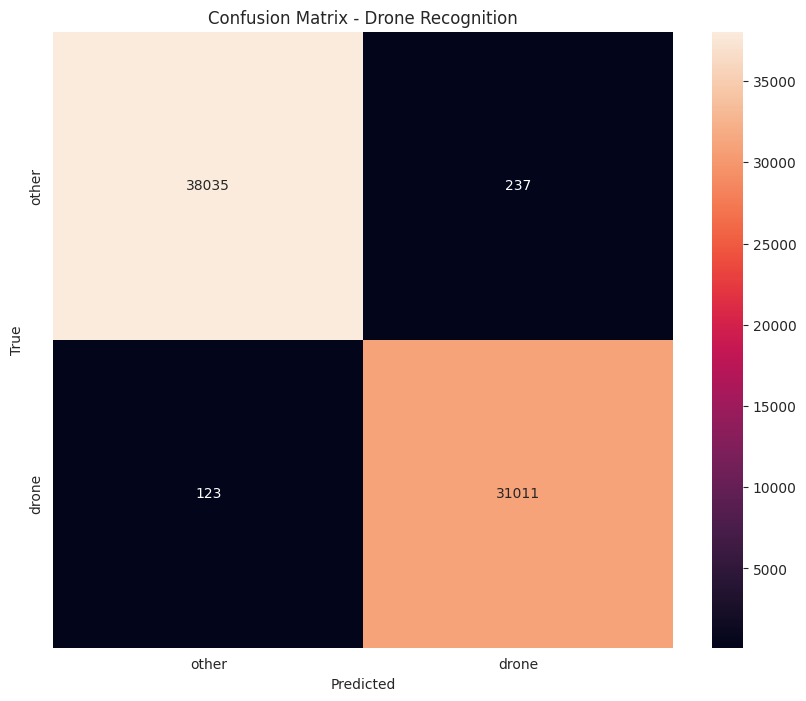

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

print(classification_report(y_true, y_pred, target_names=LABELS.names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=LABELS.names, yticklabels=LABELS.names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Drone Recognition")
plt.show()


In [41]:
import torch
import torchaudio
import pandas as pd
from pathlib import Path

# === Config ===
SAMPLE_RATE = 16000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# === Load Model ===
model = AudioCNN2D(n_classes=len(LABELS.names)).to(DEVICE)
model.load_state_dict(torch.load("best_model_2dcnn.pt", map_location=DEVICE))
model.eval()


# === Recordings list ===
recordings = [
    ("/home/pierre/Downloads/B_S2_D1_092-bebop_000_.wav", "drone"),
    ("/home/pierre/Downloads/B_S2_D1_067-bebop_000_.wav", "drone"),
    ("/home/pierre/Documents/Projects/PST4/AI/data/raw/test/drone/1.wav", "drone"),
    ("/home/pierre/Documents/Projects/PST4/AI/data/raw/test/drone/2.wav", "drone"),
    ("/home/pierre/Documents/Projects/PST4/AI/data/raw/test/drone/3.wav", "drone"),
    ("/home/pierre/Downloads/audio.wav", "drone"),
    ("/home/pierre/Documents/Projects/PST4/AI/data/raw/archive(1)/DREGON_clean_recordings_whitenoise/DREGON_clean_recordings_whitenoise/60_-15_1.2.wav", "other"),
    ("/home/pierre/Documents/Projects/PST4/AI/data/raw/archive(1)/DREGON_clean_recordings_whitenoise/DREGON_clean_recordings_whitenoise/75_-15_2.4.wav", "other"),
    ("/home/pierre/Documents/Projects/PST4/AI/data/raw/archive(1)/DREGON_clean_recordings_speech/DREGON_clean_recordings_speech/45_0_1.2__3.wav", "other"),
    ("/home/pierre/Documents/Projects/PST4/AI/data/raw/test/other/1.wav", "other"),
    ("/home/pierre/Documents/Projects/PST4/AI/data/raw/hibou_dataset/drone/2997-2997.wav", "drone"),
]

# === Prediction function ===
def predict_audio(model, path):
    waveform, sr = torchaudio.load(path)

    # Convert to mono if needed
    if waveform.ndim > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # Resample if necessary
    if sr != SAMPLE_RATE:
        resampler = torchaudio.transforms.Resample(sr, SAMPLE_RATE)
        waveform = resampler(waveform)

    mel = mel_transform(waveform)
    mel_db = db_transform(mel)

    mel_db = mel_db.unsqueeze(0).to(DEVICE)  # (1, 1, n_mels, time)
    with torch.no_grad():
        out = model(mel_db)
        pred_idx = out.argmax(dim=1).item()
        pred_label = LABELS.int2str(pred_idx)
        prob = torch.softmax(out, dim=1)[0, pred_idx].item()
    return pred_label, prob

# === Run inference for all files ===
results = []

for path, true_label in recordings:
    if not Path(path).exists():
        print(f"⚠️ File not found: {path}")
        continue
    pred_label, prob = predict_audio(model, path)
    results.append({
        "file": Path(path).name,
        "true_label": true_label,
        "pred_label": pred_label,
        "is_good": true_label == pred_label,
        "confidence": round(prob, 3)
    })

# === Display results as table ===
df_results = pd.DataFrame(results)
print(df_results)

# Optional: show nicely formatted output
display(df_results.style.background_gradient(subset=["confidence"], cmap="Blues"))

⚠️ File not found: /home/pierre/Documents/Projects/PST4/AI/data/raw/test/drone/1.wav
⚠️ File not found: /home/pierre/Documents/Projects/PST4/AI/data/raw/test/drone/2.wav
⚠️ File not found: /home/pierre/Documents/Projects/PST4/AI/data/raw/test/drone/3.wav
⚠️ File not found: /home/pierre/Documents/Projects/PST4/AI/data/raw/archive(1)/DREGON_clean_recordings_whitenoise/DREGON_clean_recordings_whitenoise/60_-15_1.2.wav
⚠️ File not found: /home/pierre/Documents/Projects/PST4/AI/data/raw/archive(1)/DREGON_clean_recordings_whitenoise/DREGON_clean_recordings_whitenoise/75_-15_2.4.wav
⚠️ File not found: /home/pierre/Documents/Projects/PST4/AI/data/raw/archive(1)/DREGON_clean_recordings_speech/DREGON_clean_recordings_speech/45_0_1.2__3.wav
⚠️ File not found: /home/pierre/Documents/Projects/PST4/AI/data/raw/test/other/1.wav
⚠️ File not found: /home/pierre/Documents/Projects/PST4/AI/data/raw/hibou_dataset/drone/2997-2997.wav
                         file true_label pred_label  is_good  confidence


/home/pierre/.local/lib/python3.13/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


,file,true_label,pred_label,is_good,confidence
0,B_S2_D1_092-bebop_000_.wav,drone,drone,True,1.000000
1,B_S2_D1_067-bebop_000_.wav,drone,drone,True,1.000000
2,audio.wav,drone,drone,True,1.000000


In [14]:
# === Collect all .wav files with true labels from subfolders ===
base_dir = Path("/home/pierre/Documents/Projects/PST4/AI/data/raw/test/")
recordings = []
for class_folder in ["drone", "other"]:
    for file_path in (base_dir / class_folder).glob("*.wav"):
        recordings.append((str(file_path), class_folder))

# === Run inference ===
results = []
for path, true_label in tqdm(recordings, desc="Inference"):
    pred_label, prob = predict_audio(model, path)
    correct = (pred_label == true_label)
    results.append({
        "file": Path(path).name,
        "true_label": true_label,
        "pred_label": pred_label,
        "confidence": round(prob, 3),
        "correct": correct
    })

# === Create DataFrame and display results ===
df_results = pd.DataFrame(results)
print(df_results)

# Optional: highlight correct vs incorrect
# display(df_results.style
#         .background_gradient(subset=["confidence"], cmap="Blues")
#         .applymap(lambda v: "background-color:#aaffaa" if v else "background-color:#ffaaaa", subset=["correct"])
#        )

# === Summary accuracy ===
accuracy = df_results["correct"].mean()
print(f"\n✅ Global accuracy on test directory: {accuracy*100:.2f}%")

Inference:   0%|          | 0/893 [00:00<?, ?it/s]/home/pierre/.local/lib/python3.13/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
Inference: 100%|██████████| 893/893 [00:00<00:00, 1247.19it/s]

                                                file true_label pred_label  \
0    drone-sound-128-ytshorts.savetube.me_chunk1.wav      drone      other   
1    drone-sound-128-ytshorts.savetube.me_chunk2.wav      drone      drone   
2    drone-sound-128-ytshorts.savetube.me_chunk3.wav      drone      drone   
3    drone-sound-128-ytshorts.savetube.me_chunk4.wav      drone      drone   
4    drone-sound-128-ytshorts.savetube.me_chunk5.wav      drone      drone   
..                                               ...        ...        ...   
888                                   209_chunk1.wav      other      other   
889                                   209_chunk2.wav      other      other   
890                                   210_chunk1.wav      other      other   
891                                   210_chunk2.wav      other      other   
892                                   211_chunk1.wav      other      drone   

     confidence  correct  
0         1.000    False  
1        

In [19]:
dataset = load_dataset("Usernameeeeee/drone_test", split="test", download_mode="force_redownload")

Generating test split: 100%|██████████| 893/893 [00:00<00:00, 21765.86 examples/s]


'drone'

In [43]:
from datasets import load_dataset
import torchaudio
import torch
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# === Config ===
SAMPLE_RATE = 16000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example placeholders – define your own
LABELS = dataset.features["label"]  # Replace with dataset.features["label"]

# === Unified Prediction Function ===
def predict_audio(model, audio_input, sample_rate=None):
    if isinstance(audio_input, str) or isinstance(audio_input, Path):
        waveform, sr = torchaudio.load(audio_input)
    else:
        waveform = torch.tensor(audio_input["array"]).unsqueeze(0)
        sr = audio_input["sampling_rate"]

    if waveform.ndim > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    if sr != SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)

    mel = mel_transform(waveform)
    mel_db = db_transform(mel).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        out = model(mel_db)
        probs = torch.softmax(out, dim=1)
        pred_idx = probs.argmax(dim=1).item()
        pred_label = LABELS.int2str(int(pred_idx))
        prob = probs[0, pred_idx].item()

    return pred_label, prob


# === Inference Loop ===
results = []
for item in tqdm(dataset, desc="Inference"):
    pred_label, prob = predict_audio(model, item["audio"])
    true_label = LABELS.int2str(int(item["label"])) if "label" in item else None

    results.append({
        "file": item.get("filename", "N/A"),
        "true_label": true_label,
        "pred_label": pred_label,
        "confidence": round(prob, 3),
        "correct": (pred_label == true_label) if true_label is not None else None
    })


# === Results DataFrame ===
df_results = pd.DataFrame(results)

# Optional notebook styling (omit for scripts)
try:
    display(df_results.style
        .background_gradient(subset=["confidence"], cmap="Blues")
        .apply(lambda col: ["background-color:#aaffaa" if v else "background-color:#ffaaaa"
                            for v in col] if col.name == "correct" else col))
except Exception:
    pass


# === Summary Accuracy ===
if df_results["correct"].notna().any():
    accuracy = df_results["correct"].mean()
    print(f"\nGlobal accuracy: {accuracy*100:.2f}%")


Inference: 100%|██████████| 893/893 [00:00<00:00, 1133.77it/s]


ValueError: Styles supplied as string must follow CSS rule formats, for example 'attr: val;'. '0_chunk1.wav' was given.


Global accuracy: 43.00%
